# Završni rad - Otkrivanje znanja u podacima

1.	Razumijevanje problema


2.	Priprema podataka


3.	Istraživačka analiza podataka


4.	Oblikovanje baznog modela, balansiranje podataka, particija podataka (treniranje i testiranje)
- filtriramo cjelokupni dataframe na [titleType=movie]
- svodimo cjelokupni dataframe na [naslov_filma, režiser, žanrovi, prosječna_ocjena]

5.	Primjena različitih postupaka strojnog učenja


6.	Odabir najboljeg modela, evaluacija (u odnosu na bazni model, model treba biti osjetljiv na cijenu pogreške)


7.	Primjena u stvarnim uvjetima

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import settings
from prepare import TITLES_DTYPE

titles_df = pd.read_csv(os.path.join(settings.DATASET_DIR, 'titles.csv'), dtype=TITLES_DTYPE)
titles_df['genres'] = titles_df['genres'].apply(eval)

rename_map = {
    'tconst'          : 'tconst',
    'averageRating'   : 'Prosječna ocjena',
    'numVotes'        : 'Broj glasova',
    'titleType'       : 'Tip naslova',
    'primaryTitle'    : 'Naziv naslova',
    'isAdult'         : 'Odrasli naslov',
    'startYear'       : 'Godina',
    'runtimeMinutes'  : 'Trajanje (min)',
    'genres'          : 'Žanrovi',
}

include_types = ('short', 'movie', 'video', 'tvMovie')
titles_df = titles_df[titles_df['titleType'].isin(include_types)]

<AxesSubplot:title={'center':'Broj naslova po tipu naslova'}>

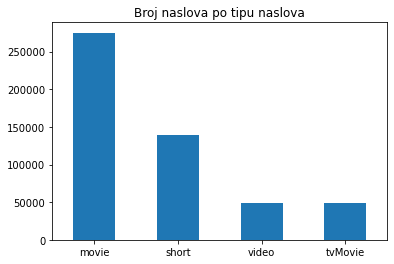

In [118]:
titles_df['titleType'].value_counts().plot.bar(title='Broj naslova po tipu naslova', rot=0)

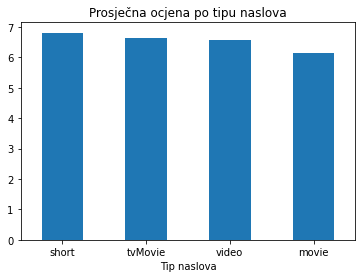

In [129]:
titles_df[['titleType', 'averageRating']].rename(columns=rename_map) \
    .groupby(rename_map['titleType'])[rename_map['averageRating']].mean() \
    .sort_values(ascending=False) \
    .plot.bar(title="Prosječna ocjena po tipu naslova", rot=0)
plt.show()

Pretpostavka: Što je veći broj uzoraka, opada njihova kvaliteta (prosječna ocjena)

<AxesSubplot:title={'center':'Suma prosječnih ocjena po žanru'}, ylabel='genres'>

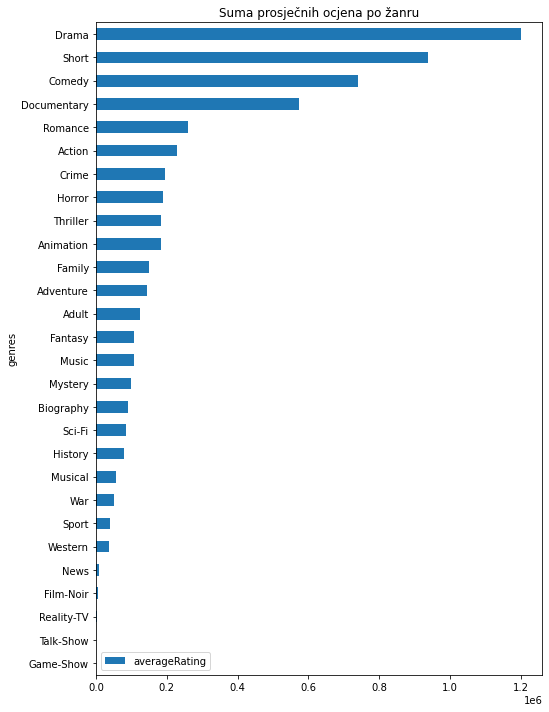

In [25]:
gdf = titles_df[['titleType', 'averageRating', 'genres']].explode('genres').reset_index().set_index('index')
# gdf['genreRating'] = gdf.groupby('index')['averageRating'].mean() / gdf.groupby('index')['averageRating'].size()
gdf.groupby('genres')[['averageRating']].sum().sort_values('averageRating').plot.barh(title='Suma prosječnih ocjena po žanru', figsize=(8, 12))
plt.show()

In [57]:
titles_df.sample(10)

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
193919,tt0413815,7.0,11,video,Barely Legal 46,Barely Legal 46,1,2003,82,[Adult]
220039,tt0497533,7.4,25,short,The Tape,The Tape,0,2005,16,"[Comedy, Short]"
278359,tt1268906,6.5,109,movie,Samudram,Samudram,0,1999,0,"[Action, Drama, Thriller]"
336314,tt1792135,8.2,8,short,The Big Idea,The Big Idea,0,2010,3,"[Comedy, Drama, Short]"
278312,tt1268300,5.9,20,video,We Suck! POV Tag-Team Suck-Off,We Suck! POV Tag-Team Suck-Off,1,2008,170,[Adult]
455417,tt5822766,5.1,136,movie,Love and Other Catastrophes,Kærlighed og andre katastrofer,0,2016,100,"[Comedy, Drama, Romance]"
294273,tt1374961,6.8,10,video,Grand Guignol: A Theatrical Tradition,Grand Guignol: A Theatrical Tradition,0,2008,20,"[Documentary, Short]"
57527,tt0086403,6.8,229,movie,Szerencsés Dániel,Szerencsés Dániel,0,1983,87,"[Comedy, Drama, Thriller]"
405902,tt3524792,7.1,278,movie,The Furthest End Awaits,Saihate nite,0,2014,118,[Drama]
105930,tt0174050,5.6,10,tvMovie,Mörderisches Erbe - Tausch mit einer Toten,Mörderisches Erbe - Tausch mit einer Toten,0,1998,93,[Thriller]


In [73]:
titles_df[(titles_df['numVotes'] >= 5000) & (titles_df['titleType'] == 'movie')][['primaryTitle', 'startYear', 'genres', 'numVotes', 'averageRating']].sort_values('averageRating', ascending=False).reset_index(drop=True)

,primaryTitle,startYear,genres,numVotes,averageRating
0,The Silence of Swastika,2021,"[Documentary, History]",5018,9.9
1,Methagu,2021,"[Biography, History]",8646,9.5
2,The Chaos Class,1975,"[Comedy, Drama]",39737,9.3
3,The Shawshank Redemption,1994,[Drama],2547412,9.3
4,Jai Bhim,2021,"[Crime, Drama, Mystery]",174954,9.3
...,...,...,...,...,...
14686,Potato Salad,2015,"[Comedy, Horror]",6833,1.3
14687,Smolensk,2016,"[Drama, Thriller]",38544,1.2
14688,Sadak 2,2020,"[Action, Drama]",93763,1.1
14689,Cumali Ceber,2017,[Comedy],38756,1.0


In [70]:
titles_df[(titles_df['numVotes'] >= 64) & (titles_df['titleType'] == 'movie')][
    ['primaryTitle', 'startYear', 'genres', 'numVotes', 'averageRating']
].sort_values('averageRating', ascending=False).reset_index(drop=True)

,primaryTitle,startYear,genres,numVotes,averageRating
0,Queer Icon: The Cult of Bette Davis,2009,[Documentary],222,10.0
1,Electric Burma,2012,[Documentary],185,10.0
2,Days of Géants II,2020,[Documentary],188,10.0
3,Days of Géants,2019,"[Documentary, Sport]",206,10.0
4,Wild Horses and Renegades,2010,"[Documentary, Western]",200,10.0
...,...,...,...,...,...
132238,A Light in the Distance,2014,[Drama],412,1.0
132239,Sakura sakura sakura,2017,[],97,1.0
132240,Jocking Around,2007,[Documentary],181,1.0
132241,The Advocate Celebrates 50 Years: A Long Road ...,2018,[Documentary],175,1.0


In [15]:
title_principals_df = pd.read_csv(os.path.join(settings.DATASET_DIR, 'title.principals.tsv.gz'), compression='gzip', sep='\t')
name_basics_df = pd.read_csv(os.path.join(settings.DATASET_DIR, 'name.basics.tsv.gz'), compression='gzip', sep='\t')
title_crew_df = pd.read_csv(os.path.join(settings.DATASET_DIR, 'title.crew.tsv.gz'), compression='gzip', sep='\t')

In [84]:
tpdf = title_principals_df[(title_principals_df['category'] == 'director')][['tconst', 'category', 'ordering', 'nconst']]
tpdf = tpdf.merge(titles_df, on='tconst')

In [90]:
tpdf['ordering'] = tpdf.sort_values('ordering') \
             .groupby(['tconst']) \
             .cumcount() + 1
tpdf = tpdf[tpdf['ordering'] == 1]
tpdf = tpdf.merge(name_basics_df[['nconst', 'primaryName']].rename(columns={'primaryName': 'directorName'}), on='nconst')

In [93]:
columns = [
    'tconst',
    'nconst',
    'titleType',
    'primaryTitle',
    'directorName',
    'category',
    'genres',
    'numVotes',
    'averageRating',
]
tpdf = tpdf[columns]
tpdf

,tconst,nconst,titleType,primaryTitle,directorName,category,genres,numVotes,averageRating
0,tt0000001,nm0005690,short,Carmencita,William K.L. Dickson,director,"[Documentary, Short]",1863,5.7
1,tt0000005,nm0005690,short,Blacksmith Scene,William K.L. Dickson,director,"[Comedy, Short]",2458,6.2
2,tt0000006,nm0005690,short,Chinese Opium Den,William K.L. Dickson,director,[Short],164,5.2
3,tt0000007,nm0005690,short,Corbett and Courtney Before the Kinetograph,William K.L. Dickson,director,"[Short, Sport]",765,5.4
4,tt0000008,nm0005690,short,Edison Kinetoscopic Record of a Sneeze,William K.L. Dickson,director,"[Documentary, Short]",2006,5.4
...,...,...,...,...,...,...,...,...,...
457434,tt9915872,nm8063415,movie,The Last White Witch,Hideki Kiyota,director,"[Comedy, Drama, Fantasy]",8,6.9
457435,tt9916038,nm1517212,short,Eco,Aitor de Miguel,director,"[Drama, Short]",12,6.0
457436,tt9916170,nm5412267,movie,The Rehearsal,Tamar Guimaraes,director,[Drama],5,7.2
457437,tt9916190,nm7308376,movie,Safeguard,Fraser Precious,director,"[Action, Adventure, Thriller]",231,3.6


In [100]:
g_tpdf = tpdf.groupby('directorName').mean()
g_tpdf[['titleType']].sort_values('averageRating', ascending=False)

,numVotes,averageRating
directorName,,
Somdip Dey,6.058824,10.0
Alexander Eisfeld,24.000000,10.0
Natalee Dacquisto,5.000000,10.0
Bibek Panda,11.000000,10.0
Luís Gleiser,10.000000,10.0
...,...,...
Lily Williams,8.000000,1.0
Jeffrey Morin,12.000000,1.0
Jer Rucinski,5.000000,1.0


tvEpisode       585988
movie           275128
short           139524
tvSeries         80296
video            49228
tvMovie          48353
tvMiniSeries     12988
videoGame        12926
tvSpecial        10225
tvShort           2411
Name: titleType, dtype: int64